In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from importlib import reload

import tensorflow as tf

In [2]:
import domain
import network
import PINN

## Sampling points in the domain

<IPython.core.display.Javascript object>


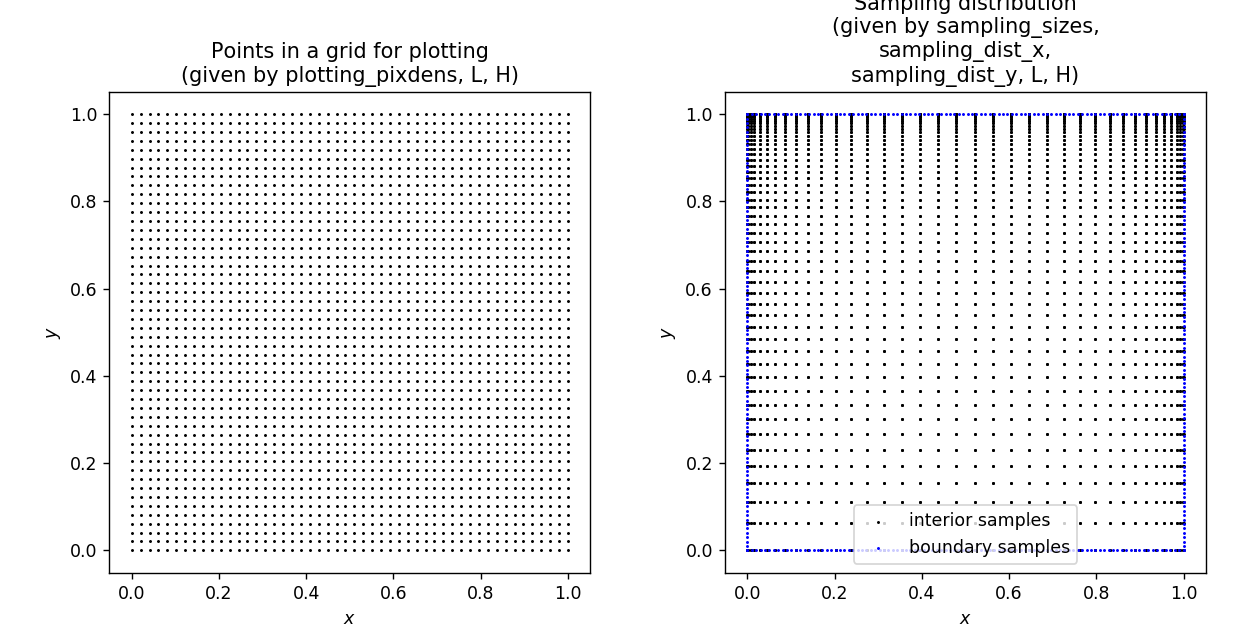

In [3]:
reload(domain)

# Domain dimensions
L     = 1
H     = 1

D    = domain.rectangular_domain(L=L, H=H, plotting_pixdens = 50, sampling_sizes = (75,50),
                                 sampling_dist_x = lambda x: np.sin(np.pi*x)**2,
                                 sampling_dist_y = lambda y: np.sin(np.pi*y/2)**0.8)

fig, axs = plt.subplots(1,2, figsize = (10*L,5*H))

axs[0].set_title("Points in a grid for plotting\n(given by plotting_pixdens, L, H)")
axs[0].scatter(D.plotting_grid[:,0], D.plotting_grid[:,1], s = 0.5, color = 'k')

D.update_samples()

axs[1].set_title("Sampling distribution\n(given by sampling_sizes,\nsampling_dist_x,\nsampling_dist_y, L, H)")
axs[1].scatter(D.interior_samples[:,0],D.interior_samples[:,1], s = 0.5, c = 'k', label = 'interior samples')
axs[1].scatter(D.boundary_samples[:,0],D.boundary_samples[:,1], s = 0.5, c = 'b', label = 'boundary samples')
axs[1].legend()

for ax in axs:
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_aspect('equal','box')
    
fig.tight_layout()
fig.canvas.draw();

fig.savefig('sampling_yeet.png')

## The network architecture

<IPython.core.display.Javascript object>


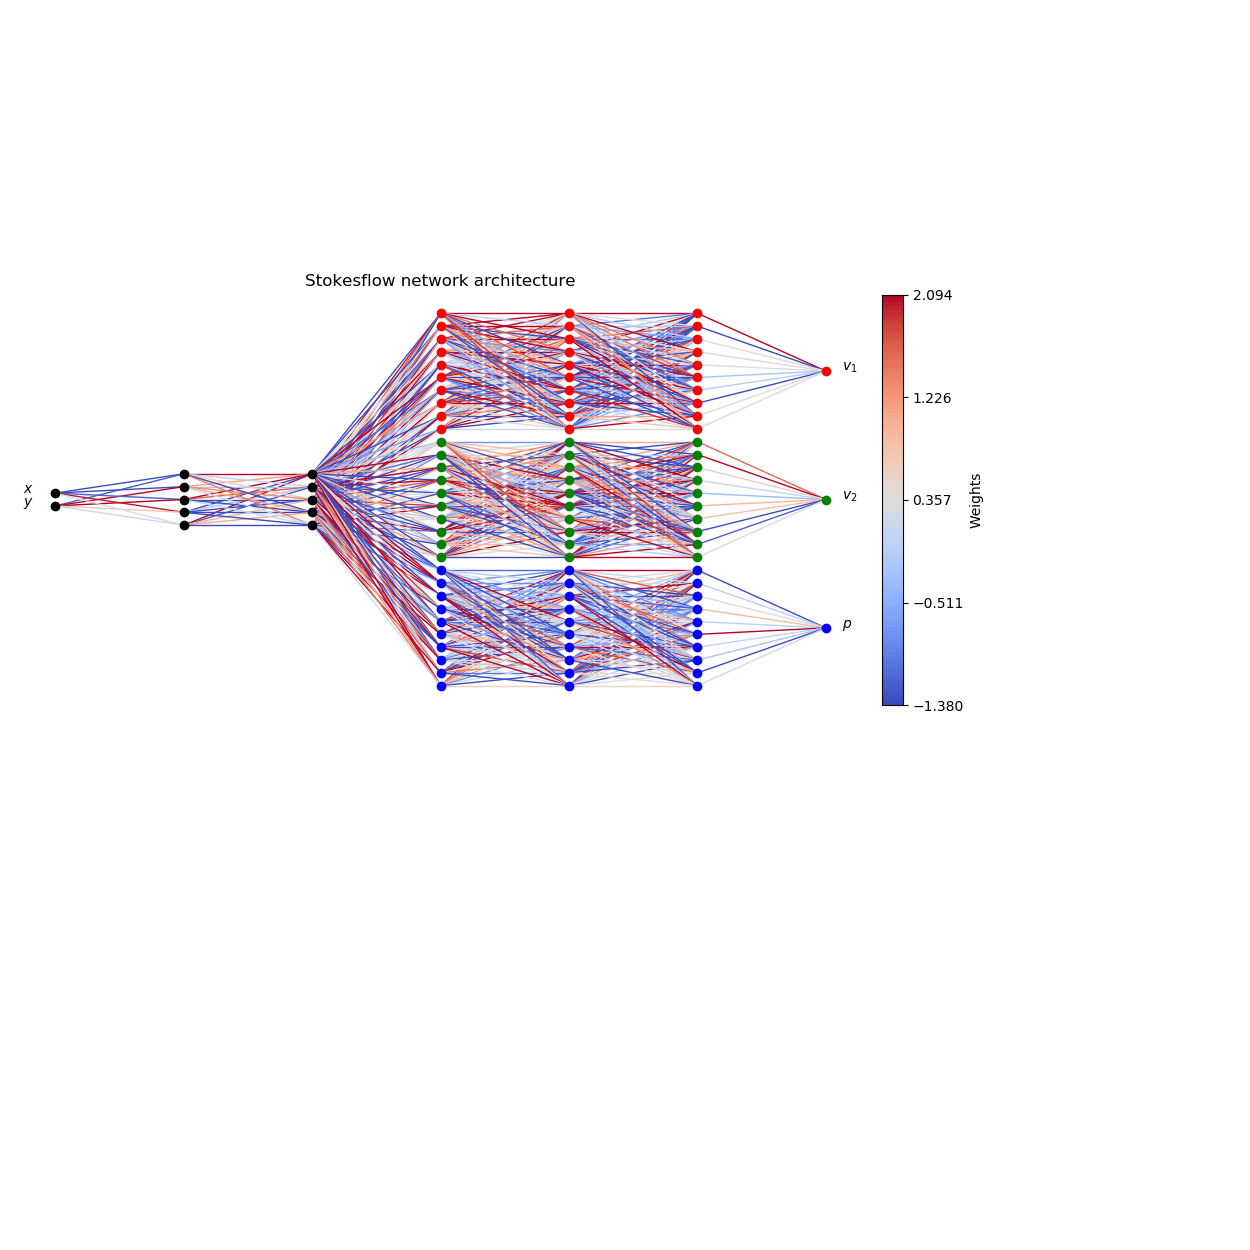

Model: "Stokesflow_branched"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_layer_0 (InputLayer)      [(None, 2)]          0                                            
__________________________________________________________________________________________________
stem_1 (Dense)                  (None, 5)            15          Input_layer_0[0][0]              
__________________________________________________________________________________________________
stem_2 (Dense)                  (None, 5)            30          stem_1[0][0]                     
__________________________________________________________________________________________________
v1-branch_3 (Dense)             (None, 10)           60          stem_2[0][0]                     
________________________________________________________________________________

In [6]:
reload(network)
reload(PINN)

# Note: here we use the second class form both the network and the PINN scripts, the first one is for the warm-up exericse

# Model = network.construct_model_stokesflow(hidden_layer_widths = np.array(7*[10]),
#                                            activation_function = tf.nn.tanh)

model_assembler = network.model_stokesflow_branched(branch_widths = 3*[10])
Model = model_assembler.assemble_full_model()
model_assembler.plot_model(spacing_x = 10, figsize = (10,10))
Model.summary()

# Optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,
#                                      beta_1=0.99,
#                                      epsilon=1e-7)
Optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08)

# Defining functions that descrive the boundary conditions (in order left, right, top bottom, standard is all 0)
BCs_v1    = 4*[lambda x: 0*x]
BCs_v1[2] = lambda x: 0*x +1

# Standard we have f = 0
# The loss weights are in the order incompressibility, PDE, boundaries

loss_weights = np.array([10,1,10])
loss_weights = loss_weights/np.sum(loss_weights) # always normalize weights

NN = PINN.PINN_object_stokesflow(D, Model, Optimizer, BCs_v1 = BCs_v1, loss_weights = loss_weights)
NN.compute_f_and_BC_values()

## Training

<IPython.core.display.Javascript object>


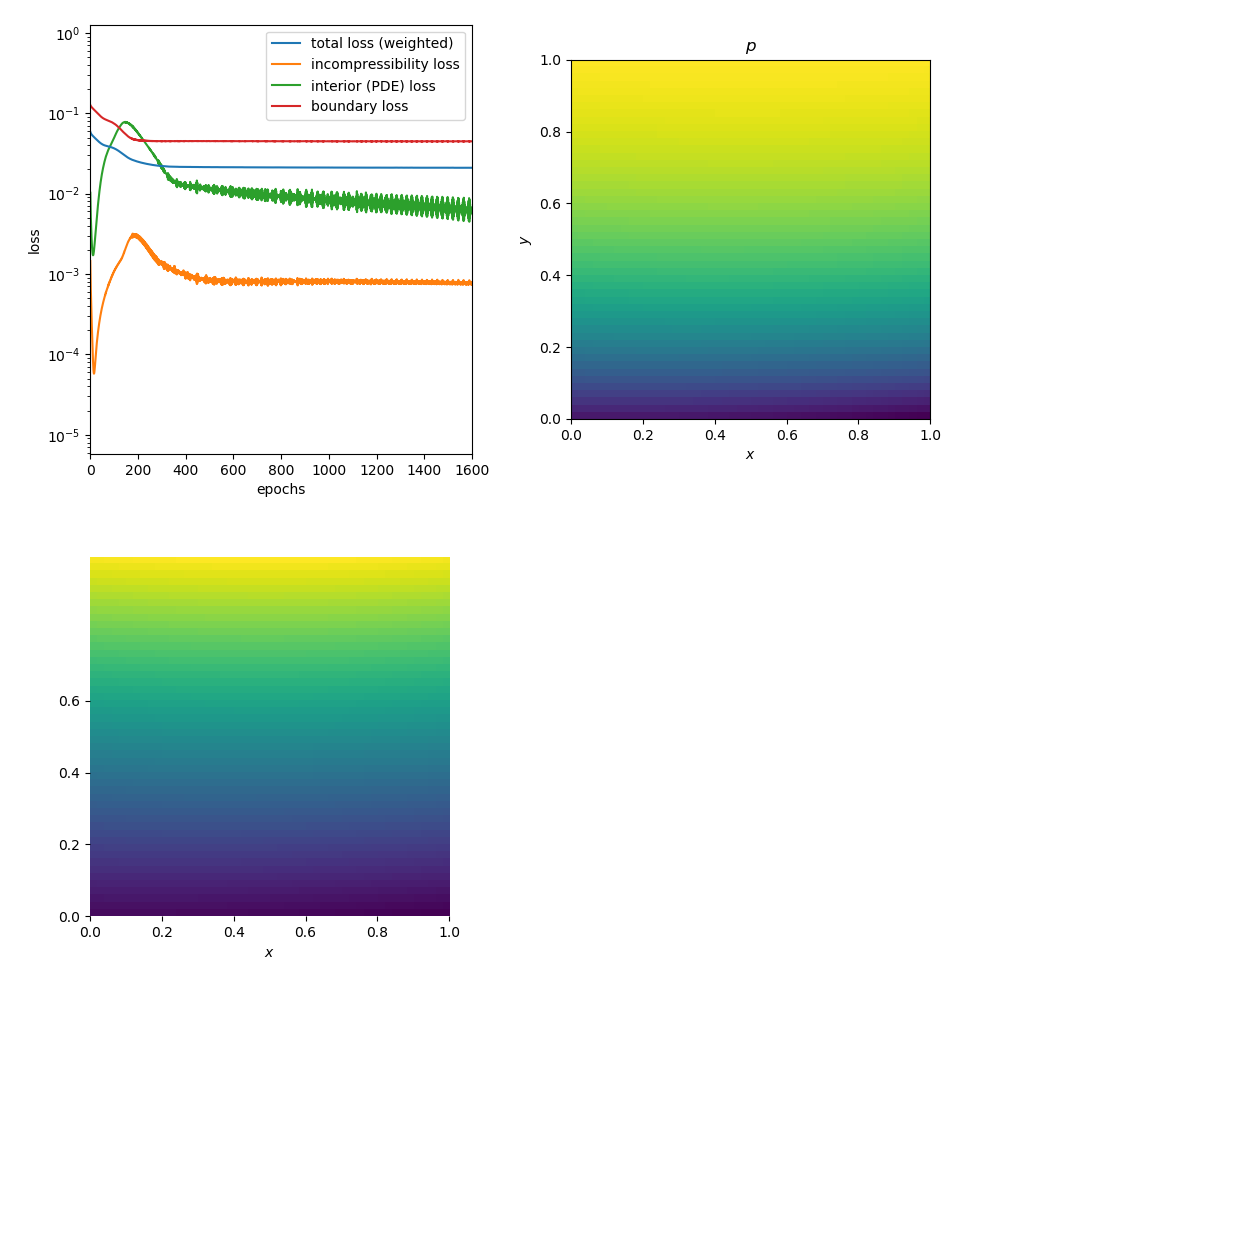

KeyboardInterrupt: 

In [5]:
NN.fit(n_epochs = 10000,
       plot_update_interval = 50);

## Gridsearch

In [1]:
from itertools import product
import csv
import numpy as np
import tensorflow as tf
import domain
import network
import PINN

n_epochs       = 100
stem_lengths   = range(6)
stem_widths    = range(1,6)
branch_lengths = range(1,6)
branch_widths  = range(1,6)
learning_rate  = 1e-3
loss_weights   = [10,1,100]

# Domain
D = domain.rectangular_domain(sampling_sizes = (75,50),
                              sampling_dist_x = lambda x: np.sin(np.pi*x)**2,
                              sampling_dist_y = lambda y: np.sin(np.pi*y/2)**0.8)

# Boundary conditions
BCs_v1    = 4*[lambda x: 0*x]
BCs_v1[2] = lambda x: 0*x +1

Parameter_combinations = list(product(stem_lengths,
                                      stem_widths,
                                      branch_lengths,
                                      branch_widths))

no_param_combis = len(Parameter_combinations)
print(f'Number of parameter combinations: {no_param_combis}')

Number of parameter combinations: 750


In [2]:
with open('gridsearch_log.csv', mode = 'w', newline = '') as csv_file:
    
    writer = csv.writer(csv_file, delimiter = ',')
    writer.writerow(['final_loss','stem_length','stem_width','branch_length','branch_width','learning_rate'])

    for i, (stem_length, stem_width, branch_length, branch_width) in enumerate(Parameter_combinations):

        # Set up model
        model_assembler = network.model_stokesflow_branched(stem_widths   = stem_length*[stem_width],
                                                            branch_widths = branch_length*[branch_width])
        Model     = model_assembler.assemble_full_model()
        Optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=1e-08)
        NN        = PINN.PINN_object_stokesflow(D, Model, Optimizer, BCs_v1 = BCs_v1, loss_weights = loss_weights)

        # Training
        NN.fit(n_epochs = n_epochs, show_progress = False);

        # Save data
        final_loss = NN.losses_total[-1]
        data       = [final_loss,stem_length,stem_width,branch_length,branch_width,learning_rate]
        writer.writerow(data)
        print(f'({i+1}/{no_param_combis}): {data}')

(1/750): [11.269707, 0, 1, 1, 1, 0.001]
(2/750): [7.536678, 0, 1, 1, 2, 0.001]
(3/750): [9.823752, 0, 1, 1, 3, 0.001]
(4/750): [8.518589, 0, 1, 1, 4, 0.001]
(5/750): [14.913325, 0, 1, 1, 5, 0.001]
(6/750): [11.085522, 0, 1, 2, 1, 0.001]
(7/750): [11.030971, 0, 1, 2, 2, 0.001]
(8/750): [6.8840613, 0, 1, 2, 3, 0.001]
(9/750): [13.974623, 0, 1, 2, 4, 0.001]
(10/750): [5.232841, 0, 1, 2, 5, 0.001]
(11/750): [10.051326, 0, 1, 3, 1, 0.001]
(12/750): [8.584429, 0, 1, 3, 2, 0.001]
(13/750): [9.450731, 0, 1, 3, 3, 0.001]
(14/750): [12.750181, 0, 1, 3, 4, 0.001]
(15/750): [4.395388, 0, 1, 3, 5, 0.001]
(16/750): [9.413295, 0, 1, 4, 1, 0.001]
(17/750): [10.50238, 0, 1, 4, 2, 0.001]
(18/750): [9.949701, 0, 1, 4, 3, 0.001]
(19/750): [8.069931, 0, 1, 4, 4, 0.001]
(20/750): [8.087025, 0, 1, 4, 5, 0.001]
(21/750): [11.210493, 0, 1, 5, 1, 0.001]
(22/750): [9.072318, 0, 1, 5, 2, 0.001]
(23/750): [9.907141, 0, 1, 5, 3, 0.001]
(24/750): [8.131712, 0, 1, 5, 4, 0.001]
(25/750): [5.954178, 0, 1, 5, 5, 0.001]


(380/750): [9.8811865, 3, 1, 1, 5, 0.001]
(381/750): [10.790517, 3, 1, 2, 1, 0.001]
(382/750): [10.310045, 3, 1, 2, 2, 0.001]
(383/750): [9.40875, 3, 1, 2, 3, 0.001]
(384/750): [9.327717, 3, 1, 2, 4, 0.001]
(385/750): [9.496308, 3, 1, 2, 5, 0.001]
(386/750): [9.875355, 3, 1, 3, 1, 0.001]
(387/750): [9.514523, 3, 1, 3, 2, 0.001]
(388/750): [9.7344675, 3, 1, 3, 3, 0.001]
(389/750): [9.490253, 3, 1, 3, 4, 0.001]
(390/750): [8.862322, 3, 1, 3, 5, 0.001]
(391/750): [10.826394, 3, 1, 4, 1, 0.001]
(392/750): [10.161297, 3, 1, 4, 2, 0.001]
(393/750): [9.520539, 3, 1, 4, 3, 0.001]
(394/750): [9.133715, 3, 1, 4, 4, 0.001]
(395/750): [8.252592, 3, 1, 4, 5, 0.001]
(396/750): [10.13858, 3, 1, 5, 1, 0.001]
(397/750): [10.355792, 3, 1, 5, 2, 0.001]
(398/750): [9.432445, 3, 1, 5, 3, 0.001]
(399/750): [9.33403, 3, 1, 5, 4, 0.001]
(400/750): [15.893689, 3, 1, 5, 5, 0.001]
(401/750): [9.908799, 3, 2, 1, 1, 0.001]
(402/750): [10.449398, 3, 2, 1, 2, 0.001]
(403/750): [9.766851, 3, 2, 1, 3, 0.001]
(404/750)

In [3]:
import pandas as pd

gridsearch_data = pd.read_csv('gridsearch_log.csv')
gridsearch_data

,final_loss,stem_length,stem_width,branch_length,branch_width,learning_rate
0,11.269707,0,1,1,1,0.001
1,7.536678,0,1,1,2,0.001
2,9.823752,0,1,1,3,0.001
3,8.518589,0,1,1,4,0.001
4,14.913325,0,1,1,5,0.001
...,...,...,...,...,...,...
745,6.394451,5,5,5,1,0.001
746,9.727060,5,5,5,2,0.001
747,8.373961,5,5,5,3,0.001
748,9.257725,5,5,5,4,0.001


In [4]:
min_loss_index = gridsearch_data['final_loss'].idxmin()
gridsearch_data.iloc[min_loss_index]

final_loss       4.316704
stem_length      0.000000
stem_width       2.000000
branch_length    2.000000
branch_width     5.000000
learning_rate    0.001000
Name: 34, dtype: float64

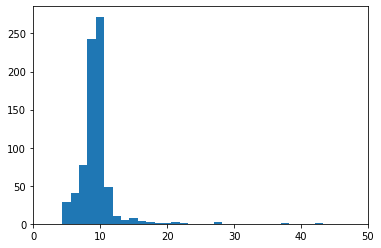

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.hist(gridsearch_data['final_loss'], bins = 250)
ax.set_xlim(0,50);